# LOAD MAP

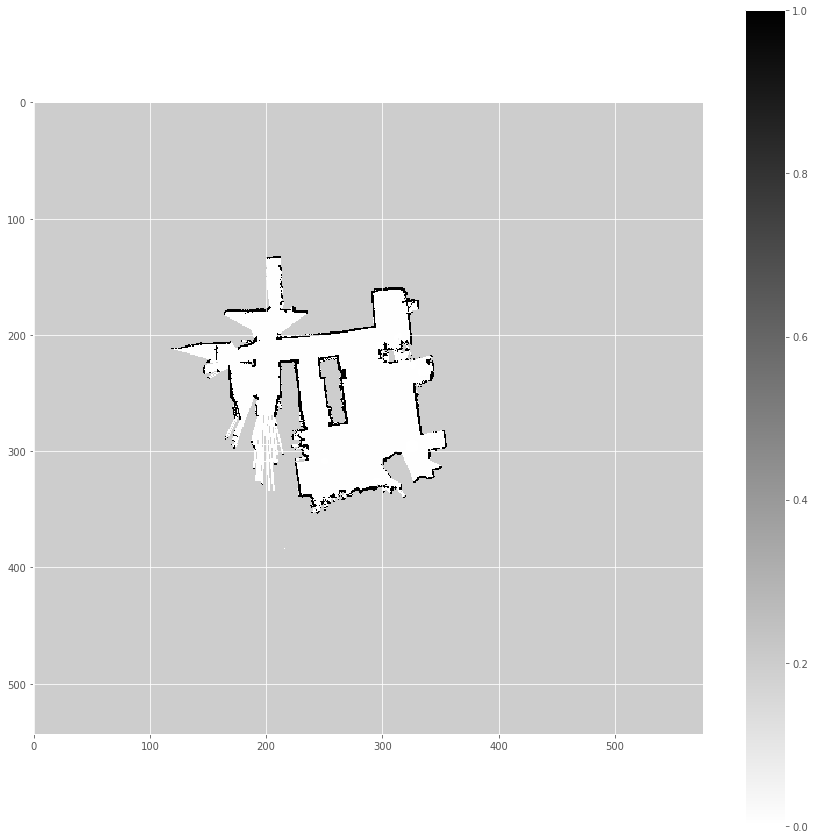

In [1]:
import re
import numpy
from matplotlib import pyplot as plt
plt.style.use('ggplot')

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return (255-numpy.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width))))/255.0


# map_ = read_pgm("willow-2010-02-18-0.10.pgm", byteorder='<')
map_ = read_pgm("maps/test_map.pgm", byteorder='<')


plt.figure(figsize=(15,15))
plt.imshow(map_, plt.cm.binary)
plt.colorbar()
plt.show()

In [2]:
%%time
all_nodes=[]
for x in range(map_.shape[0]):
    for y in range(map_.shape[1]):
        if map_[x,y] < 0.196:
            all_nodes.append((x,y))
len(all_nodes)

CPU times: user 92.4 ms, sys: 9 µs, total: 92.4 ms
Wall time: 90.9 ms


19713

## The Graph

A graph-based pathfinding algorithm needs to know what the locations are and also which locations are connected to which other ones. A mathematical graph is a set of nodes and edges. The nodes are connected together by the edges. A square **grid** is a special type of graph, where each (free) cell is a node. The edges connecting ajacent cells are going to be the four directions (or eight if diagonal movement is allowed). 

For any node we need to know the other nodes connected to this one by an edge. We call these **neighbors** of a node:

In [3]:
class Graph:
    
    #Nodes
    def __init__(self):
        self.all_nodes=[]
    
    #Edges
    def neighbors(self,node):
        dirs = [[1, 0],
                [0, 1],
                [-1, 0],
                [0, -1],
                [-1, -1],
                [-1, 1],
                [1, -1],
                [1, 1]]
        
#         dirs = [[1, 0], [0, 1], [-1, 0], [0, -1]]
        result = []
        for dir in dirs:
            neighbor = (node[0] + dir[0], node[1] + dir[1])
            if neighbor in self.all_nodes:
                result.append(neighbor)

        return result

graph = Graph()
graph.all_nodes=all_nodes

## Breadth First Search Algorithm

In [4]:
import collections

class Queue:
    def __init__(self):
        self.elements = collections.deque()
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, x):
        self.elements.append(x)
    
    def get(self):
        return self.elements.popleft()

In [5]:
%%time
def breadth_first_search(start,graph):

    frontier = Queue()
    frontier.put(start)
    
    visited = {}
    visited[start] = True
    
    while not frontier.empty():
        current = frontier.get()
        #print("Visiting {}".format(current))
        for next in graph.neighbors(current):
            if next not in visited:
                frontier.put(next)
                visited[next] = True
    
    print(len(visited))

breadth_first_search((300,300),graph)

19492
CPU times: user 24.6 s, sys: 0 ns, total: 24.6 s
Wall time: 24.6 s


In [6]:
%%time
def breadth_first_search(start,goal,graph):

    frontier = Queue()
    frontier.put(start)
    came_from = {}
    came_from[start] = None
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for node in graph.neighbors(current):
            if node not in came_from:
                frontier.put(node)
                came_from[node] = current
    
    return came_from

res=breadth_first_search((300,300), (200, 200),graph)
print(len(res))

14386
CPU times: user 20.9 s, sys: 16.8 ms, total: 20.9 s
Wall time: 21 s


In [7]:
def reconstruct_path(start,goal,came_from):
    """
    """
    current = goal 
    path = []
    while current != start: 
        path.append(current)
        current = came_from[current]
    path.append(start) # optional
    path.reverse() # optional
    return path

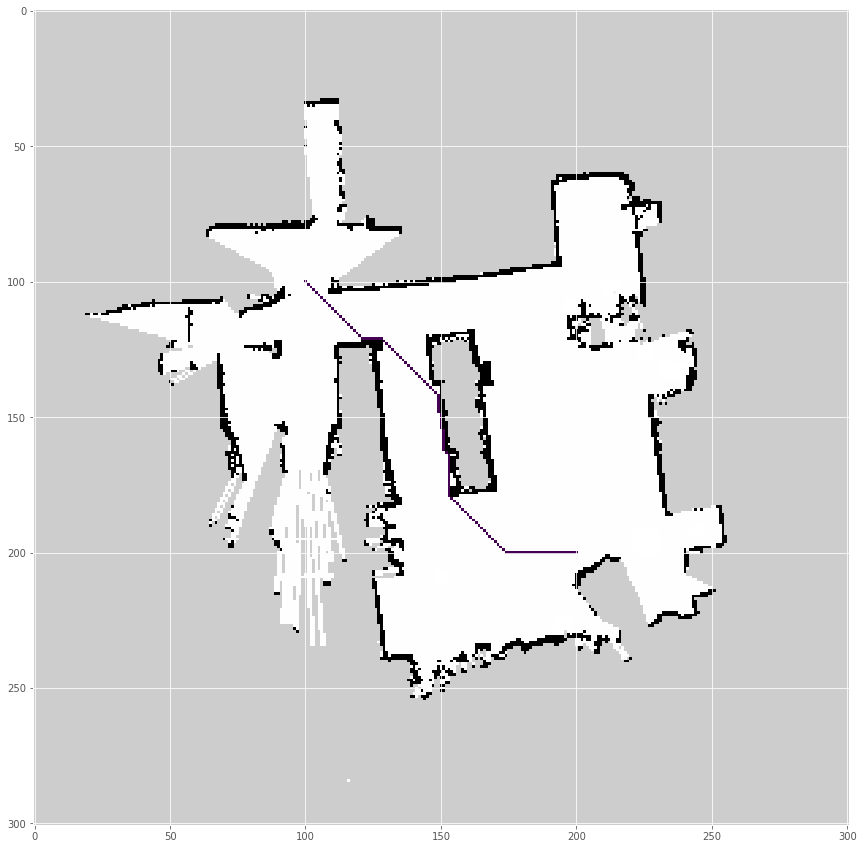

In [33]:
path_overlay=numpy.zeros_like(map_)
for step in reconstruct_path((300,300), (200, 200),res):
    path_overlay[step[0],step[1]]=1
    
path_overlay_mask = numpy.ma.masked_where(path_overlay == 0, path_overlay) 
    
plt.figure(figsize=(15,15))
plt.imshow(map_[100:401,100:401], plt.cm.binary)
plt.imshow(path_overlay_mask[100:401,100:401],interpolation="none")
#plt.colorbar()
plt.show()